# Porting DESeq into python using rpy2#

I will use a small example of [ERCC transcript](https://www.thermofisher.com/order/catalog/product/4456740) from [samples A and B in MAQC data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3272078/).

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np

We will read the table and it should only contains count data of ERCC spikeins (rows) and 3 replicates from each of samples A and B (columns).

In [2]:
#df = pd.read_table('../test/data/ercc.tsv')
df = pd.read_csv('../datasets/cancers/breast/topsbm/topsbm_level_1_topic-dist.csv', index_col=1).drop("i_doc", axis=1)
df=df.transpose().applymap(lambda p: round(p*1000)).astype(int).reset_index()
df.rename({"index":"id"}, axis=1, inplace=True)
#df.set_index("id", inplace=True)
df.columns=[c[:8] for c in df.columns]
df.head()

,id,87fcecde,bbf9a30d,c909a75f,1c89ff2f,2a6ae2e8,0a2c1866,cf1a1478,eab58571,07ad35fc,...,220d10e6,bab0168d,4270fb7c,ec9d9157,36bcb602,dff9d818,d1245d77,6419a6e7,ec631f8b,8682197b
0,Topic 1,6,2,2,10,8,0,9,2,8,...,7,2,7,11,0,2,9,0,8,2
1,Topic 2,14,7,6,21,21,13,21,12,19,...,9,11,12,18,4,10,17,5,24,13
2,Topic 3,6,2,0,3,0,2,3,0,3,...,0,2,3,2,4,0,0,0,0,6
3,Topic 4,8,5,6,6,5,7,6,7,6,...,5,7,7,6,8,5,5,5,6,8
4,Topic 5,2,2,2,4,6,2,6,4,0,...,4,4,3,6,0,2,3,2,3,0


And here, we will create a design matrix based on the samples in the count table. Note that the sample name has to be used as the ```pd.DataFrame``` index

In [3]:
#sample_df = pd.DataFrame({'samplename': df.columns}) \
#        .query('samplename != "id"')\
#        .assign(sample = lambda d: d.samplename.str.extract('([AB])_', expand=False)) \
#        .assign(replicate = lambda d: d.samplename.str.extract('_([123])', expand=False)) 
sample_df = pd.read_csv("../datasets/cancers/breast/files.dat")
sample_df.file_name=[c[:8] for c in sample_df.file_name]
sample_df.index = sample_df.file_name
sample_df=sample_df.reindex(columns=["file_name","Subtype_Selected"])

sample_df=sample_df[sample_df.index.isin(df.columns)]
sample_df.set_index("file_name", inplace=True)

sample_df["subtype"]=[str(d).split(".")[1] if "." in str(d) else d for d in sample_df["Subtype_Selected"]]
sample_df["subtype"]=["A" if "Lum" in str(d) else "B" for d in sample_df["subtype"]]
sample_df = sample_df.reindex(index=df.columns, columns=["subtype"]).dropna(how="any", axis=0)
df=df.reindex(columns=np.concatenate([["id"],df.columns[df.columns.isin(sample_df.index)]])).dropna(how="any", axis=0)
sample_df.head()

,subtype
87fcecde,A
bbf9a30d,A
c909a75f,B
1c89ff2f,B
2a6ae2e8,A


Running DESeq2 is jsut like how it is run in ```R```, but instead of the row.name being gene ID for the count table, we can jsut tell the function which column is the gene ID:

In [4]:
import sys
sys.path.append("./diffexpr/")

In [207]:
df=pd.DataFrame(columns=["id", "s1","s2","s3"], data=[["g1",1,1,1],["g2",2,3,3]])
sample_df = pd.DataFrame(columns=["subtype"], index=["s1","s2","s3"], data=["A","B","B"])

In [5]:
from diffexpr.py_deseq import py_DESeq2

dds = py_DESeq2(count_matrix = df,
               design_matrix = sample_df,
               design_formula = '~ subtype',
               gene_column = 'id') # <- telling DESeq2 this should be the gene ID column
    
dds.run_deseq() 
dds.get_deseq_result()
res = dds.deseq_result 
res.head()





   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.





,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,id
Topic 1,6.067353,0.092667,0.074694,1.240629,2.147430e-01,2.843893e-01,Topic 1
Topic 2,15.400640,0.080507,0.039880,2.018754,4.351279e-02,6.460990e-02,Topic 2
Topic 3,2.362370,-1.175475,0.078836,-14.910427,2.819418e-50,3.453787e-49,Topic 3
Topic 4,6.219586,-0.138387,0.035120,-3.940368,8.135674e-05,1.733252e-04,Topic 4
Topic 5,3.253560,0.100681,0.058339,1.725790,8.438523e-02,1.216140e-01,Topic 5


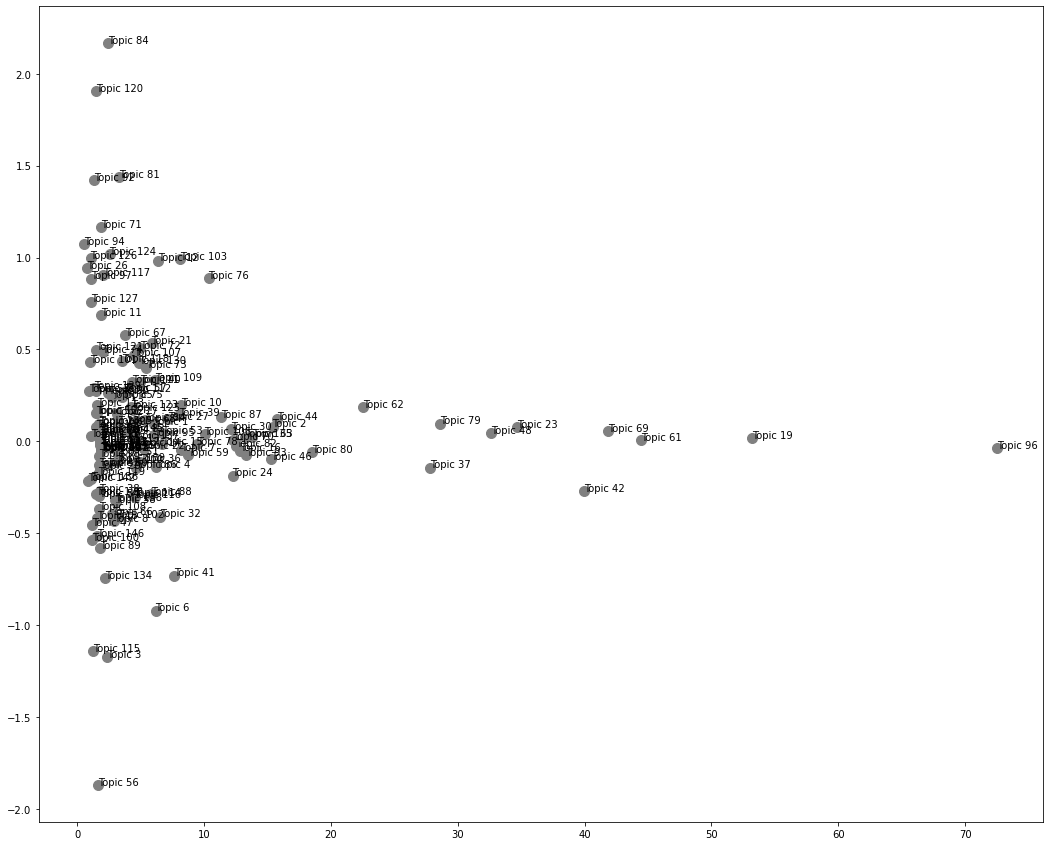

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,15))
plt.scatter(res["baseMean"],res["log2FoldChange"], marker="o", s=100, c="gray")
for (x,y, name) in zip(res["baseMean"],res["log2FoldChange"],res.index):
    plt.annotate(name,xy=(x,y))

In [11]:
list(map(print,pd.read_csv('../datasets/cancers/breast/topsbm/topsbm_level_1_topics.csv')["Topic 81"].dropna()))

ENSG00000175592
ENSG00000163661
ENSG00000163739
ENSG00000188015
ENSG00000107159
ENSG00000183036
ENSG00000108839
ENSG00000174236


[None, None, None, None, None, None, None, None]

In [ ]:
dds.normalized_count() #DESeq2 normalized count

In [ ]:
dds.comparison # show coefficients for GLM

In [151]:
# from the last cell, we see the arrangement of coefficients, 
# so that we can now use "coef" for lfcShrink
# the comparison we want to focus on is 'sample_B_vs_A', so coef = 4 will be used
lfc_res = dds.lfcShrink(coef=4, method='apeglm')
lfc_res.head()

  coef <= length(resultsNamesDDS) is not TRUE


 



RRuntimeError: Error in (function (dds, coef, contrast, res, type = c("apeglm", "ashr",  : 
  coef <= length(resultsNamesDDS) is not TRUE


In [152]:
dds.deseq_result

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,id
Topic 1,6.067353,0.091699,0.071377,1.284710,0.198894,0.974298,Topic 1
Topic 2,15.400640,0.079913,0.038098,2.097568,0.035943,0.974298,Topic 2
Topic 3,2.362370,0.029400,0.073916,0.397749,0.690815,0.974298,Topic 3
Topic 4,6.219586,0.020578,0.032839,0.626627,0.530904,0.974298,Topic 4
Topic 5,3.253560,0.029377,0.055941,0.525139,0.599487,0.974298,Topic 5
...,...,...,...,...,...,...,...
Topic 143,1.863944,-0.012584,0.059746,-0.210624,0.833180,0.974298,Topic 143
Topic 144,1.850262,-0.010850,0.059977,-0.180901,0.856445,0.974298,Topic 144
Topic 145,3.052082,0.019840,0.046980,0.422317,0.672793,0.974298,Topic 145
Topic 146,1.556784,-0.067704,0.065816,-1.028693,0.303624,0.974298,Topic 146
